# Rat RNN

### Load Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf

from unityagents import UnityEnvironment

%matplotlib inline

### Hyperparameters

In [35]:
learning_rate = 1e-4
l2_regularization = 0.1
hidden_units = 128
train_steps = 2000
ep_length = 500 # this is hard-coded into the Unity engine
sim_steps = 50000
batch_size = 8

model_path = 'rat_square_model'
data_path = 'rat_square_data'

## Generate Data
Prerequisite: Load unity project in the Editor. Build and save executable as "rat.exe" or "rat.app".

### Start Environment

In [3]:
env_name = "rat_square" # Name of the Unity environment binary to launch
env = UnityEnvironment(file_name=env_name, worker_id=1)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]

INFO:unityagents.environment:
'Academy' started successfully!


Unity Academy name: Academy
        Number of brains: 1
        Reset Parameters :
		ep_length -> 500.0
		start_area_extents -> 0.0
Unity brain name: Brain
        Number of observations (per agent): 0
        State space type: continuous
        State space size (per agent): 10
        Action space type: continuous
        Action space size (per agent): 1
        Memory space size (per agent): 0
        Action descriptions: 


### Collect States

In [4]:
x,z,ep = [], [], []
input_x = []
a = env.reset()[default_brain]
for i in range(sim_steps - 1):
    
    # check for NANs
    if a.states[0].dtype != np.float64:
        print(i, a.states[0].dtype, a.states[0])
    elif np.any(np.isnan(a.states[0])):
        print(i, "NAN", a.states[0])
        
    # append
    x.append(a.states[0][0])
    z.append(a.states[0][1])
    input_x.append(a.states[0][2:-1])
    ep.append(a.states[0][-1])

    # next simulation step
    a = env.step(0)[default_brain]

    if i % (sim_steps/10) == 0 and i != 0:
        print(i)

5000
10000
15000
20000
25000
30000
35000
40000
45000


In [5]:
x = np.array(x)
z = np.array(z)
input_x = np.array(input_x)
input_y = np.stack((x, z), axis=1)

In [13]:
print(x.shape)
print(input_x[:10])
print(np.sqrt(np.sum(input_x[:10, 1:3]**2, axis=1)))

(49999,)
[[ 0.30029958  0.          0.          0.          0.          0.04538809
   0.2514605 ]
 [ 0.30029958 -1.01787448 -0.7380659   0.28518176  1.25730252  0.04538809
   0.2514605 ]
 [ 0.3021152  -1.02206755 -0.7322484   0.28518176  1.25730264  0.04538809
   0.2514605 ]
 [ 0.30393067 -1.02622736 -0.7264072   0.28518176  1.25730264  0.04538809
   0.2514605 ]
 [ 0.3057461  -1.03035378 -0.72054213  0.28518176  1.25730264  0.04538809
   0.2514605 ]
 [ 0.30756175 -1.03444672 -0.7146536  -0.8706686   1.25730264 -0.13857122
   0.2514605 ]
 [ 0.3020189  -1.02184594 -0.7325578  -0.8706686   1.25730264 -0.13857122
   0.2514605 ]
 [ 0.29647607 -1.00893545 -0.7502395  -0.8706686   1.25730264 -0.13857122
   0.2514605 ]
 [ 0.29093313 -0.99571884 -0.7676939  -0.8706686   1.25730264 -0.13857122
   0.2514605 ]
 [ 0.28539032 -0.98220044 -0.7849153  -0.8706686   1.25730264 -0.13857122
   0.2514605 ]]
[ 0.          1.25730256  1.25730259  1.25730267  1.25730262  1.25730258
  1.25730269  1.25730269  1

So input_x[1] and input_x[2] represent velocity_x and velocity_y, respectively.

In [29]:
print( (input_y[3:13] - input_y[2:12]) / input_x[2:12, 1:3] )

[[ 0.02005618  0.01988987]
 [ 0.02005551  0.01988854]
 [ 0.02005484  0.01988718]
 [ 0.01983185  0.02034585]
 [ 0.01982559  0.02033321]
 [ 0.01981916  0.02032117]
 [ 0.01981257  0.02030968]
 [ 0.0198058   0.0202987 ]
 [ 0.01972302  0.02039427]
 [ 0.01970946  0.02037542]]


Looks like dt is approximately 0.2

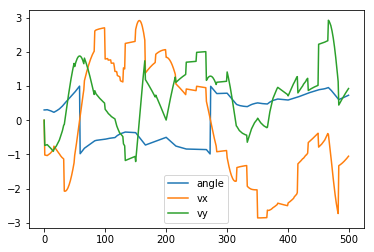

In [47]:
t = 500
x_ = np.arange(t)
angle = plt.plot(x_, input_x[:t, 0], label='angle') # euler angle
vx = plt.plot(x_, input_x[:t, 1], label='vx') # velocity x
vy = plt.plot(x_, input_x[:t, 2], label='vy') # velocity y
legend = plt.legend()

It seems like the angle is in [-1, 1] and has a discontinuity when vx crosses zero.

In [181]:
import math
angle = (input_x[:t, 0] + 1.0) * 180
print(angle)
angle_ = np.arcsin(input_x[:t, 1] / input_x[:t, 4]) * 180 / math.pi
quad_1 = np.logical_and(input_x[:t, 1] > 0, input_x[:t, 2] < 0)
quad_3 = np.logical_and(input_x[:t, 1] < 0, input_x[:t, 2] < 0)
quad_4 = np.logical_and(input_x[:t, 1] < 0, input_x[:t, 2] > 0)
angle_[quad_1] = 180 - angle_[quad_1]
angle_[quad_3] = 180 - angle_[quad_3]
angle_[quad_4] = 360 + angle_[quad_4]
angle_[angle_ < 0] = 180 - angle_[angle_ < 0]
np.set_printoptions(suppress=True)
print(angle_)

[ 234.0539253   234.0539253   234.380736    234.7075206   235.034298
  235.3611159   234.363402    233.36569188  232.36796376  231.37025706
  230.37254514  229.00387824  227.63520594  226.26653904  224.89785882
  223.52918922  221.6770488   223.44511536  225.21321     226.981296
  228.74937408  230.938236    233.12707722  235.31591538  237.50477496
  239.693616    242.70007428  245.706516    248.71298076  251.7194205
  254.72589246  258.67291338  262.61993412  266.56695486  270.100152
  273.63336318  277.1665299   280.699704    284.232906    287.76608352
  291.29925006  294.832458    298.365624    301.8988359   305.43200262
  308.965212    312.498378    316.03158828  319.564755    323.097966
  326.631132    330.745788    334.86043806  338.97512916  343.089792
  347.20443612  351.31909482  355.433778    359.548434      3.66309
    7.77775176   11.89242      16.007076     20.12173884   24.23639772
   28.351062     32.4657261    34.801452     37.13715792   39.472866
   41.80858974   44.14

/home/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


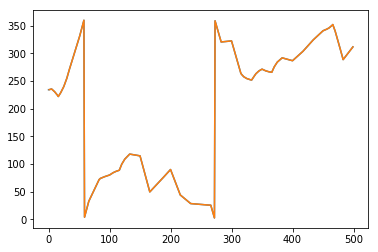

In [182]:
plt.plot(angle)
plt.plot(angle_)
# Fix this: estimated angle is reflected from actual angle in range [90, 270]

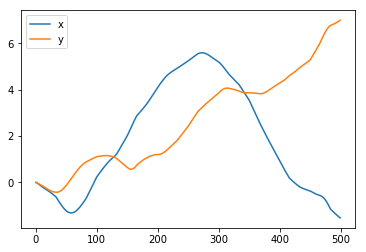

In [141]:
plt.plot(input_y[:t, 0], label='x')
plt.plot(input_y[:t, 1], label='y')
legend = plt.legend()

So the angle and speed are `input_x[0]` and `input_x[4]`, respectively.

### Save Training Data

In [71]:
if not os.path.exists(data_path):
    os.makedirs(data_path)

save_data = {"x": input_x, "y": input_y}
pickle.dump(save_data, open(data_path+"/data.p", "wb"))

## Load Training Data

In [109]:
save_data = pickle.load(open(data_path+"/data.p", "rb"))
input_x = save_data["x"]
input_y = save_data["y"]
x = input_y[:, 0]
z = input_y[:, 1]

In [ ]:
input_x = input_x[:, [0, 4]] # select angle, speed
#input_x = input_x[:, -2:] # select heading, velocity from observable state

### Visualize Rat Trajectory

In [73]:
def create_colors(length, segments):
    c_list = []
    for i in range(segments):
        color = np.zeros([length//segments, 4])
        color[:, 3] = 0.5
        color[:, 0:3] = np.random.uniform(0, 1, size=[1, 3])
        c_list.append(color)
    c_list = np.reshape(c_list, [length, 4])
    return c_list

(-10, 10)

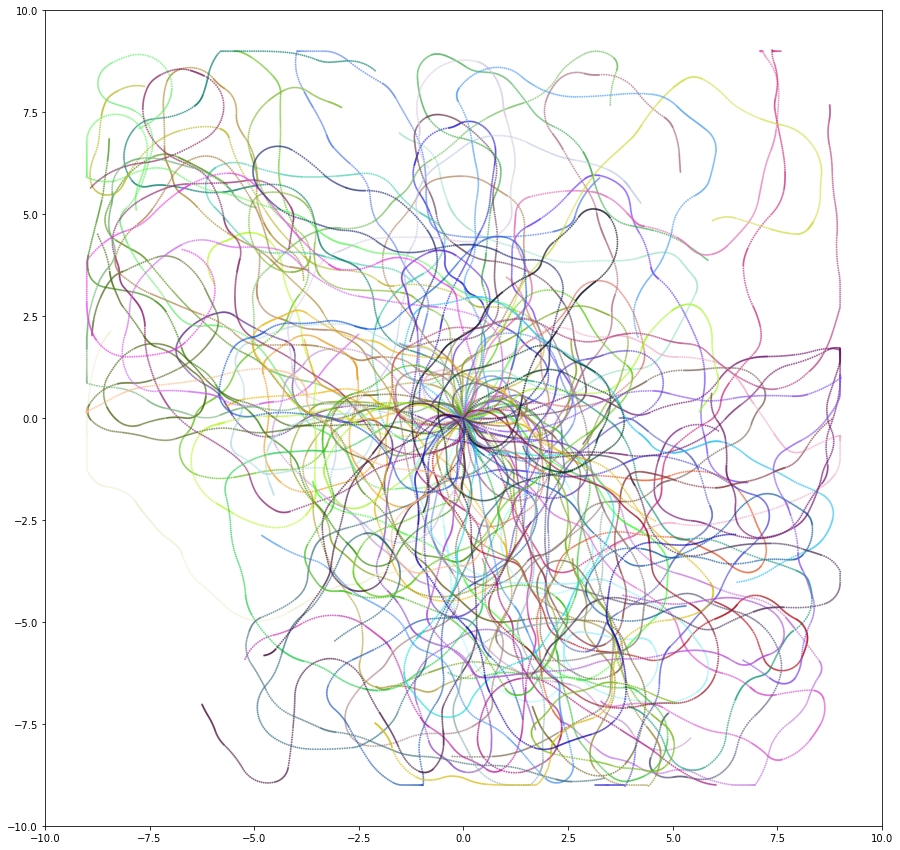

In [74]:
plt.figure(figsize=(15, 15))
plt.scatter(x, z, s=1, c=create_colors(sim_steps, sim_steps//ep_length))
plt.ylim(-10, 10)
plt.xlim(-10, 10)

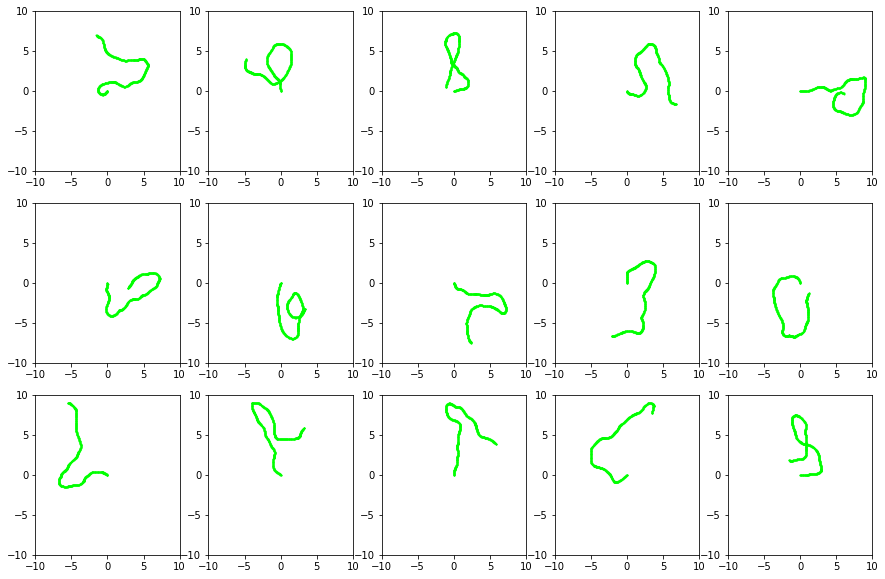

In [75]:
plt.figure(figsize=(15,10))
for i in range(15):
    pointer = i
    batch_y = input_y[pointer*ep_length:(pointer+1)*ep_length]
    
    plt.subplot(3, 5, 1 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
plt.show()

## Rat RNN

### Define Network

In [76]:
class RatRNN(object):
    def __init__(self, x_size, y_size, h_size, lr):
        self.x = tf.placeholder(shape=[None, x_size], dtype=tf.float32)
        self.train_length = tf.placeholder(shape=[1], dtype=tf.int32)
        self.batch_size = tf.placeholder(shape=[1], dtype=tf.int32)

        self.rnn_in = tf.reshape(self.x, shape=[self.batch_size[0], self.train_length[0], x_size])

        cell = tf.contrib.rnn.BasicLSTMCell(h_size, state_is_tuple=True)
        self.state_in = cell.zero_state(self.batch_size[0], tf.float32)

        self.rnn, self.rnn_state = tf.nn.dynamic_rnn(inputs=self.rnn_in, cell=cell, dtype=tf.float32,
                                                     initial_state=self.state_in)

        self.output = tf.reshape(self.rnn, shape=[-1, h_size])
        
        self.y_pred = tf.layers.dense(self.output, y_size, activation=None)

        self.y = tf.placeholder(shape=[None, y_size], dtype=tf.float32)

        #l2_loss_a = tf.reduce_sum(tf.nn.l2_loss(tf.trainable_variables()[0]))
        #l2_loss_b = tf.reduce_sum(tf.nn.l2_loss(tf.trainable_variables()[1]))
        
        lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in tf.trainable_variables()
        #lossL2 = tf.add_n([ tf.reduce_sum(tf.abs(v)) for v in tf.trainable_variables()
                           if 'bias' not in v.name ]) * l2_regularization

        self.l2_loss = lossL2 # l2_loss_a + l2_loss_b
        self.regress_loss = tf.reduce_sum(tf.squared_difference(self.y, self.y_pred))
        self.loss = self.regress_loss + self.l2_loss

        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update = optimizer.minimize(self.loss)

In [106]:
tf.reset_default_graph()
rat_rnn = RatRNN(2, 2, hidden_units, learning_rate)
sess = tf.InteractiveSession()
saver = tf.train.Saver()

### Train Network

500 100.0


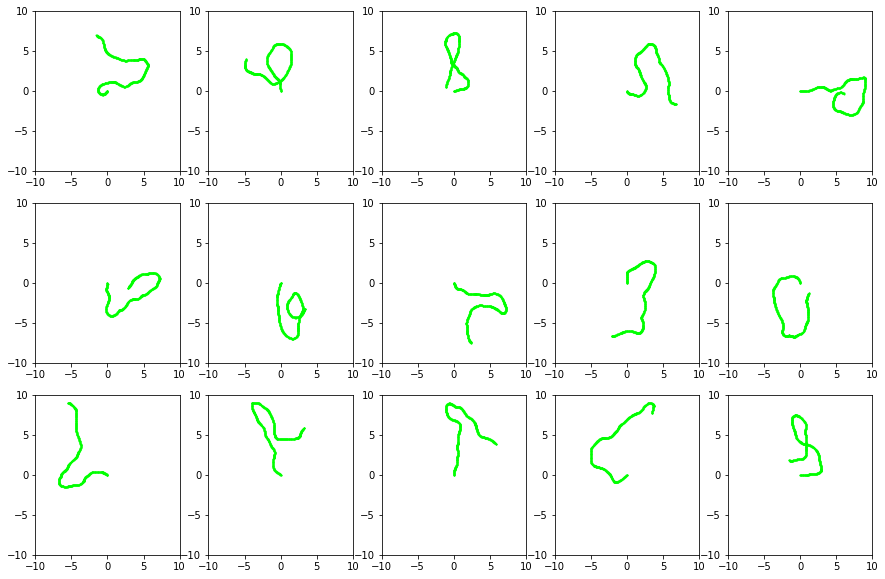

In [86]:
losses = []
init = tf.global_variables_initializer()
sess.run(init)
print(ep_length, sim_steps/ep_length)

# center training data
input_Y = np.copy(input_y)
for i in range(sim_steps//ep_length):
    pointer = i
    input_Y[pointer*ep_length:(pointer+1)*ep_length] -= input_Y[pointer*ep_length]

# debug viz
plt.figure(figsize=(15,10))
for i in range(15):
    pointer = i
    batch_y = input_Y[pointer*ep_length:(pointer+1)*ep_length]
    
    plt.subplot(3, 5, 1 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
plt.show()

Loss: 113226.03125 -- 1
Loss: 157030.765625 -- 2
Loss: 87403.4375 -- 3
Loss: 105548.453125 -- 4
Loss: 135307.3125 -- 5
Loss: 112694.453125 -- 6
Loss: 84995.9140625 -- 7
Loss: 107018.09375 -- 8
Loss: 158195.765625 -- 9
Loss: 70588.8359375 -- 10
Loss: 85172.09375 -- 11
Loss: 30941.544921875 -- 12
Loss: 62241.578125 -- 13
Loss: 32241.109375 -- 14
Loss: 35222.93359375 -- 15
Loss: 69268.75 -- 16
Loss: 56891.734375 -- 17
Loss: 66705.375 -- 18
Loss: 46684.91015625 -- 19


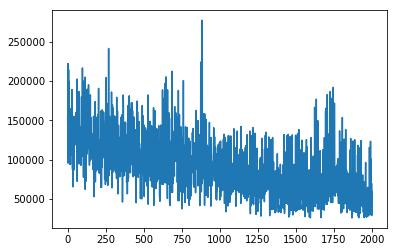

In [88]:
for i in range(train_steps):
    pointer = np.random.randint(0, sim_steps/ep_length - batch_size)
    batch_x = input_x[pointer*ep_length:(pointer+batch_size)*ep_length]
    batch_y = input_Y[pointer*ep_length:(pointer+batch_size)*ep_length]
    
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1, 2]), rat_rnn.y: np.reshape(batch_y, [-1, 2]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.batch_size: [batch_size]}
    loss, _ = sess.run([rat_rnn.loss, rat_rnn.update], feed_dict=feed_dict)
    if i % 100 == 0 and i != 0:
        print("Loss: {} -- {}".format(loss, i//100))
    losses.append(loss)
plt.plot(losses)

### Save Network Weights

In [89]:
if not os.path.exists(model_path):
    os.makedirs(model_path)

saver.save(sess, model_path + '/model.cptk')

'rat_square_model/model.cptk'

## Load Network Weights

In [107]:
ckpt = tf.train.get_checkpoint_state(model_path)
if ckpt == None:
  print('The model {0} could not be found. Make sure you specified the right '
    '--run-path'.format(model_path))
saver.restore(sess, ckpt.model_checkpoint_path)

### Compare Trajectories

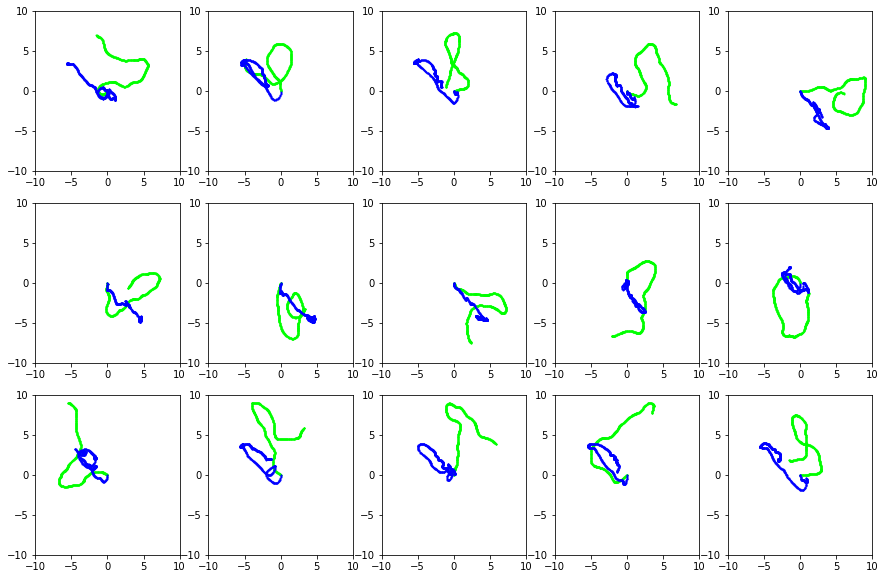

In [108]:
plt.figure(figsize=(15,10))
for i in range(15):
    pointer = i
    batch_x = input_x[pointer*ep_length:(pointer+1)*ep_length]
    batch_y = input_y[pointer*ep_length:(pointer+1)*ep_length]
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,2]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.batch_size: [1]}
    yp = sess.run(rat_rnn.y_pred, feed_dict=feed_dict) + batch_y[0]
    
    # Real - Green | Predicted - Blue
    plt.subplot(3, 5, 1 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.scatter(yp[:, 0], yp[:, 1], s=1, c=[0,0,1,1])
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
plt.show()

### Display neuron activation rates

In [101]:
resolution = 32
maze_extents = 10
rate = np.zeros([hidden_units, resolution, resolution])
for i in range(len(input_x)//ep_length):
    pointer = i
    batch_x = input_x[pointer*ep_length:(pointer+1)*ep_length]
    batch_y = input_y[pointer*ep_length:(pointer+1)*ep_length]
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,2]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.batch_size: [1]}
    act = sess.run(rat_rnn.output, feed_dict=feed_dict)
    act = np.maximum(act, 0)
    
    for h in range(hidden_units):
        for j in range(ep_length):
            x = (batch_y[j][0] + maze_extents)/(maze_extents*2) * resolution
            y = (batch_y[j][1] + maze_extents)/(maze_extents*2) * resolution
            rate[h, int(x), int(y)] += act[j, h]

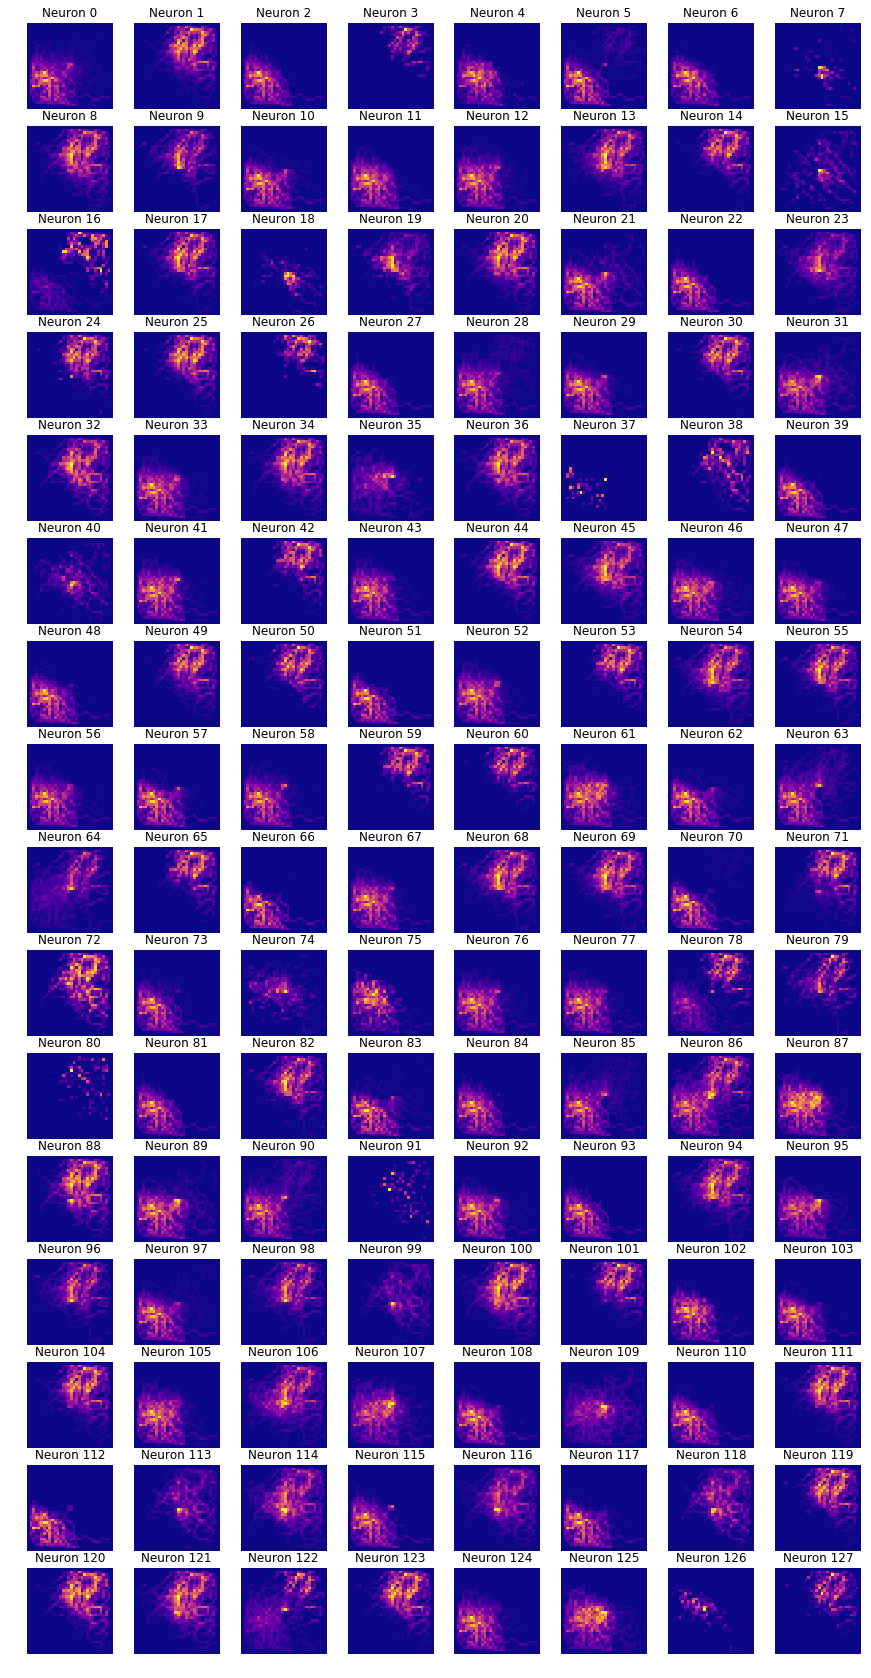

In [102]:
plt.figure(figsize=(15,30))
for h in range(hidden_units):
    plt.subplot(hidden_units//8, 8, 1 + h)
    plt.title('Neuron ' + str(h))
    plt.imshow(rate[h,:,:] / np.max(rate[h,:,:]), interpolation="nearest", cmap="plasma")
    plt.axis('off')
    
plt.show()

### Close TensorFlow Session & Environment

In [103]:
sess.close()
env.close()